In [1]:
%load_ext autoreload
%autoreload 2

import sys,glob,os,errno

import numpy as np
import astropy.units as u 
import matplotlib.pyplot as plt

### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from hydrogen import (
    get_tbabs_template_model,
)

from gammapy.datasets import Datasets
from gammapy.modeling.models import Models
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

## Datasets and models

In [2]:
basedir = os.path.abspath("../../../")
datasetdir  = f"{basedir}/XRT/MJD60373/"

# load the dataset and models (without hydrogen-absorption), assuming we start from the Notebooks directory
xrt_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")
xrt_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))
xrt_datasets[0].mask_fit = xrt_datasets[0].counts.geom.energy_mask(0.3*u.keV, 10*u.keV)
xrt_datasets[0].mask_safe = xrt_datasets[0].counts.geom.energy_mask(0.2*u.keV, 12*u.keV)

# add the hydrogen absorption from the 2D table (output from sherpa's / xspec's tbabs). It is the same for XRT.
absorption_model = get_tbabs_template_model(f"{basedir}/Models/tbabs_tau_factor_vs_nH_energy.ecsv",srcname="OP313")
absorption_model.parameters['nH'].frozen = True

xrt_datasets.models['OP313'].spectral_model *= absorption_model

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


## Fit and flux points

In [3]:
# Define a fit
xrt_only_fit    = Fit(store_trace=True)
xrt_only_result = xrt_only_fit.run(xrt_datasets)
# we make a copy here for later comparisons
xrt_only_model = xrt_datasets.models.copy()
# spectral points
energy_edges = np.geomspace(0.3*u.keV, 10*u.keV, 10)
xrt_only_fpe = FluxPointsEstimator(energy_edges=energy_edges, source="OP313", selection_optional="all")
xrt_only_points = xrt_only_fpe.run(xrt_datasets).copy()

No dataset contribute in range 0.442924806581943 keV-0.6539412809521721 keV


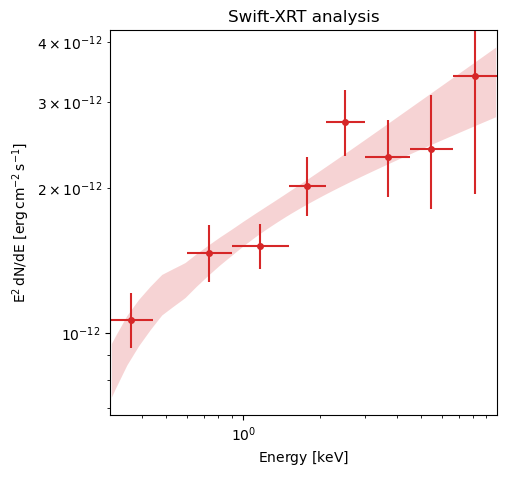

In [4]:
fig = plt.figure(figsize=(5, 5),dpi=100)

ax = xrt_only_model['OP313'].spectral_model.plot_error(
    [energy_edges[0],energy_edges[-1]],
    facecolor='tab:red',
    sed_type='e2dnde')

xrt_only_points.plot(
    ax=ax, color="tab:red", sed_type='e2dnde',
)
ax.set_title('Swift-XRT analysis')
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')
!mkdir -p {basedir}/Figures/MJD60373/Swift-XRT
fig.savefig(f'{basedir}/Figures/MJD60373/Swift-XRT/BestFit_Swift-XRT.pdf')

In [5]:
xrt_only_model['OP313']

SkyModel(spatial_model=None, spectral_model=<gammapy.modeling.models.spectral.CompoundSpectralModel object at 0x7fa5fac92b90>)temporal_model=None)

<Axes: xlabel='Energy [$\\mathrm{keV}$]', ylabel='Residuals (data - model)'>

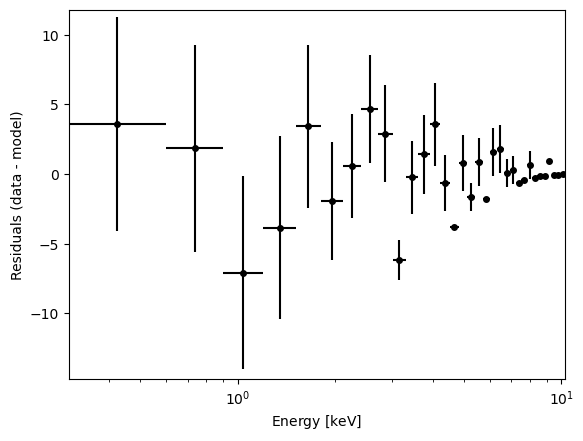

In [6]:
xrt_datasets[0].plot_residuals_spectral()